Found 3352 images belonging to 7 classes.
Found 176 images belonging to 7 classes.
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 524ms/step - accuracy: 0.1816 - loss: 1.9263 - val_accuracy: 0.1591 - val_loss: 2.0019
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 526ms/step - accuracy: 0.2602 - loss: 1.8804 - val_accuracy: 0.1193 - val_loss: 2.0583
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 529ms/step - accuracy: 0.2476 - loss: 1.8990 - val_accuracy: 0.1193 - val_loss: 2.0081
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 532ms/step - accuracy: 0.2572 - loss: 1.8535 - val_accuracy: 0.1648 - val_loss: 2.1002
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 526ms/step - accuracy: 0.2766 - loss: 1.8558 - val_accuracy: 0.1761 - val_loss: 1.9853
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step - accuracy: 0.2693 - loss: 1.8340 - val_accuracy: 0.1761 - val_loss: 2.0336
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.3051 - loss: 1.8351 - val_accuracy: 0.1761 - val_loss: 1.9803
Epoch 8/10
50/

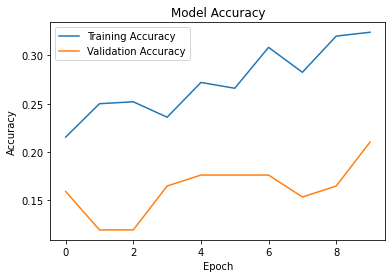

In [2]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define the feature learning model
def create_feature_learning_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)  # Replaces Flatten()
    x = Dense(128, activation='relu')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

# Define the part detector
def create_part_detector(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    output = Dense(16, activation='relu')(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

# Integrate feature learning model and part detectors into a single model
def create_combined_model(input_shape, num_detectors, num_classes):
    feature_model = create_feature_learning_model(input_shape)
    part_detectors = [create_part_detector((128,)) for _ in range(num_detectors)]
    feature_output = feature_model.output
    part_outputs = [detector(feature_output) for detector in part_detectors]
    combined_features = Concatenate()(part_outputs)
    classification_output = Dense(num_classes, activation='softmax')(combined_features)
    final_model = Model(inputs=feature_model.input, outputs=classification_output)
    return final_model


import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set up ImageDataGenerators
train_dir = r"C:\Users\Ranadeep Mahendra\OneDrive\Desktop\Cv Project\Carsdataset\train"
test_dir = r"C:\Users\Ranadeep Mahendra\OneDrive\Desktop\Cv Project\Carsdataset\test"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=10,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=10,
    class_mode='categorical'
)

# Create and compile the model
model = create_combined_model((256, 256, 3), 4, num_classes=train_generator.num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)

history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=test_generator,
    validation_steps=25
)

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


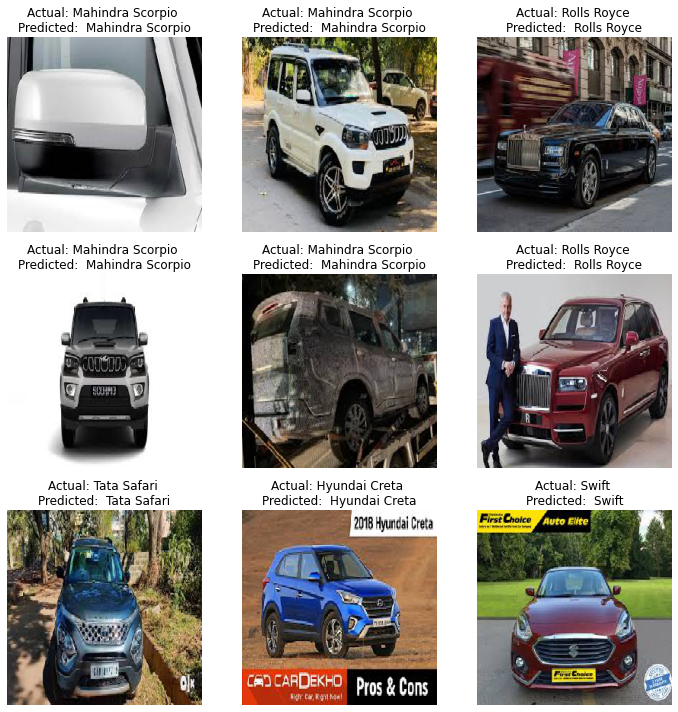

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Generate a batch from the test generator
test_images, test_labels = next(test_generator)

# Make predictions on the batch
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot the images and their predicted labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Actual: {class_labels[np.argmax(test_labels[i])]} \nPredicted:  {class_labels[np.argmax(test_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()